# 实战Kaggle比赛：预测房价
## 下载和缓存数据集
首先，我们建立字典DATA_HUB， 它可以将数据集名称的字符串映射到数据集相关的二元组上， 这个二元组包含数据集的url和验证文件完整性的sha-1密钥。 所有类似的数据集都托管在地址为DATA_URL的站点上。

In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
import sys
sys.path.append('../')
import MyTool
import matplotlib.pyplot as plt

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

下面的download函数用来下载数据集， 将数据集缓存在本地目录（默认情况下为../data）中， 并返回下载文件的名称。 如果缓存目录中已经存在此数据集文件，并且其sha-1与存储在DATA_HUB中的相匹配，我们将使用缓存的文件，以避免重复的下载。

In [2]:
# 下载一个DATA_HUB中的文件，返回本地文件名
def download(name, cache_dir=os.path.join('..', 'data')):
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

我们还需实现两个实用函数： 一个将下载并解压缩一个zip或tar文件， 另一个是将本书中使用的所有数据集从DATA_HUB下载到缓存目录中。

In [3]:
# 下载并解压zip/tar文件
def download_extract(name, folder=None):
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

# 下载DATA_HUB中的所有文件
def download_all(): 
    for name in DATA_HUB:
        download(name)

## 访问和读取数据集
数据分为训练集和测试集。 每条记录都包括房屋的属性值和属性，如街道类型、施工年份、屋顶类型、地下室状况等。 这些特征由各种数据类型组成。 例如，建筑年份由整数表示，屋顶类型由离散类别表示，其他特征由浮点数表示。 这就是现实让事情变得复杂的地方：例如，一些数据完全丢失了，缺失值被简单地标记为“NA”。 每套房子的价格只出现在训练集中（毕竟这是一场比赛）。 我们将希望划分训练集以创建验证集，但是在将预测结果上传到Kaggle之后， 我们只能在官方测试集中评估我们的模型。

开始之前，我们将使用pandas读入并处理数据。为方便起见，我们可以使用上面定义的脚本下载并缓存Kaggle房屋数据集。

In [4]:
DATA_HUB['kaggle_house_train'] = (
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

我们使用pandas分别加载包含训练数据和测试数据的两个CSV文件。

In [5]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

训练数据集包括1460个样本，每个样本80个特征和1个标签， 而测试数据集包含1459个样本，每个样本80个特征。

In [6]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


让我们看看前四个和最后两个特征，以及相应标签（房价）。

In [7]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


我们可以看到，在每个样本中，第一个特征是ID， 这有助于模型识别每个训练样本。虽然这很方便，但它不携带任何用于预测的信息。因此，在将数据提供给模型之前，我们将其从数据集中删除。

In [8]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

## 数据预处理
在开始建模之前，我们需要对数据进行预处理。首先，我们将所有缺失的值替换为相应特征的平均值。然后，为了将所有特征放在一个共同的尺度上，我们通过将特征重新缩放到零均值和单位方差来标准化数据：
$$
x \gets \frac{x-\mu}{\sigma}
$$
其中$\mu$和$\sigma$分别表示均值和标准差。现在，这些特征具有零均值和单位方差，即$E(\frac{x-\mu}{\sigma})=\frac{\mu-\mu}{\sigma}=0$和$E(x-\mu)^2=(\sigma^2+\mu^2)-2\mu^2+\mu^2=\sigma^2$。 直观地说，我们标准化数据有两个原因：首先，它方便优化。其次，因为我们不知道哪些特征是相关的，所以我们不想让惩罚分配给一个特征的系数比分配给其他任何特征的系数更大。

In [9]:
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

接下来，我们处理离散值。这包括诸如“MSZoning”之类的特征。我们用one-hot编码替换它们，方法与前面将多类别标签转换为向量的方式相同。 例如，“MSZoning”包含值“RL”和“Rm”。我们将创建两个新的指示器特征“MSZoning_RL”和“MSZoning_RM”，其值为0或1。 根据独热编码，如果“MSZoning”的原始值为“RL”，则：“MSZoning_RL”为1，“MSZoning_RM”为0。pandas软件包会自动为我们实现这一点。

In [ ]:
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 330)

可以看到此转换会将特征的总数量从79个增加到331个。最后，通过values属性，我们可以从pandas格式中提取NumPy格式，并将其转换为张量表示用于训练。

In [13]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].to_numpy(dtype=np.float32))
test_features = torch.tensor(all_features[n_train:].to_numpy(dtype=np.float32))
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

## 训练
首先，我们训练一个带有损失平方的线性模型。 显然线性模型很难让我们在竞赛中获胜，但线性模型提供了一种健全性检查， 以查看数据中是否存在有意义的信息。 如果我们在这里不能做得比随机猜测更好，那么我们很可能存在数据处理错误。 如果一切顺利，线性模型将作为基线（baseline）模型， 让我们直观地知道最好的模型有超出简单的模型多少。

In [14]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

我们在衡量评估差异的时候，常常采用的是相对误差而不是绝对误差，因此我们采用价格预测的对数来衡量差异：
$$
\mathrm{loss}=\sqrt{\frac{1}{n}\sum_{i=1}^n(\log y_i-\log\hat{y_i})^2}
$$

In [15]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf')) 
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels))) 
    return rmse.item()

与前面的部分不同，我们的训练函数将借助Adam优化器 （我们将在后面章节更详细地描述它）。 Adam优化器的主要吸引力在于它对初始学习率不那么敏感。

In [16]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = MyTool.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

## K折交叉验证
 我们首先需要定义一个函数，在K折交叉验证过程中返回第折的数据。具体地说，它选择第i个切片作为验证数据，其余部分作为训练数据。注意，这并不是处理数据的最有效方法，如果我们的数据集大得多，会有其他解决办法。

In [17]:
def get_k_fold_data(k, i, X, y):
    assert k > 1  # 确保折数k大于1
    fold_size = X.shape[0] // k  # 每折包含的样本数量
    X_train, y_train = None, None  # 初始化训练数据和标签
    for j in range(k):  # 遍历每一折
        idx = slice(j * fold_size, (j + 1) * fold_size)  # 获取第j折的样本索引范围
        X_part, y_part = X[idx, :], y[idx]  # 获取第j折的数据和标签
        if j == i:  # 如果是第i折，则将其作为验证数据
            X_valid, y_valid = X_part, y_part  # 验证数据和标签
        elif X_train is None:  # 如果训练数据尚未初始化
            X_train, y_train = X_part, y_part  # 初始化训练数据和标签
        else:  # 如果不是第i折，则将其作为训练数据的一部分
            X_train = torch.cat([X_train, X_part], 0)  # 将当前折的数据拼接到训练数据中
            y_train = torch.cat([y_train, y_part], 0)  # 将当前折的标签拼接到训练标签中
    return X_train, y_train, X_valid, y_valid  # 返回训练数据、训练标签、验证数据、验证标签

当我们在K折交叉验证中训练K次后，返回训练和验证误差的平均值。

In [20]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            plt.plot(list(range(1, num_epochs + 1)), train_ls, label='train')
            plt.plot(list(range(1, num_epochs + 1)), valid_ls, label='valid')
            plt.xlabel('epoch')
            plt.ylabel('rmse')
            plt.xlim([1, num_epochs])
            plt.yscale('log')
            plt.legend()
            plt.show()
        print(f'折{i + 1}，训练log rmse: {float(train_ls[-1]):f}, '
              f'验证log rmse: {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

## 模型选择
在本例中，我们选择了一组未调优的超参数，可以用来自行来改进模型。找到一组调优的超参数可能需要时间，这取决于一个人优化了多少变量。有了足够大的数据集和合理设置的超参数，折交叉验证往往对多次测试具有相当的稳定性。然而，如果我们尝试了不合理的超参数，我们可能会发现验证效果不再代表真正的误差。

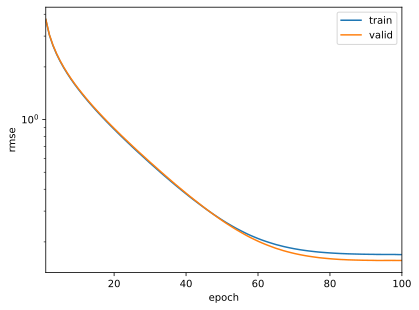

折1，训练log rmse0.169215, 验证log rmse0.156637
折2，训练log rmse0.161954, 验证log rmse0.188815
折3，训练log rmse0.164001, 验证log rmse0.168702
折4，训练log rmse0.168007, 验证log rmse0.154719
折5，训练log rmse0.163867, 验证log rmse0.183351
5-折验证: 平均训练log rmse: 0.165409, 平均验证log rmse: 0.170445


In [21]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64 # 设置超参数
# 进行K折交叉验证
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

请注意，有时一组超参数的训练误差可能非常低，但折交叉验证的误差要高得多，这表明模型过拟合了。在整个训练过程中，我们希望监控训练误差和验证误差这两个数字。较少的过拟合可能表明现有数据可以支撑一个更强大的模型，较大的过拟合可能意味着我们可以通过正则化技术来获益。
## 提交Kaggle预测
既然我们知道应该选择什么样的超参数，我们不妨使用所有数据对其进行训练（而不是仅使用交叉验证中使用的1-1/K的数据）。然后，我们通过这种方式获得的模型可以应用于测试集。将预测保存在CSV文件中可以简化将结果上传到Kaggle的过程。

In [28]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    plt.plot(np.arange(1, num_epochs + 1), train_ls, label='train')
    plt.xlabel('epoch')
    plt.ylabel('log rmse')
    plt.xlim([1, num_epochs])
    plt.yscale('log')
    plt.legend()
    plt.show()  
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

如果测试集上的预测与倍交叉验证过程中的预测相似，那就是时候把它们上传到Kaggle了。下面的代码将生成一个名为submission.csv的文件。

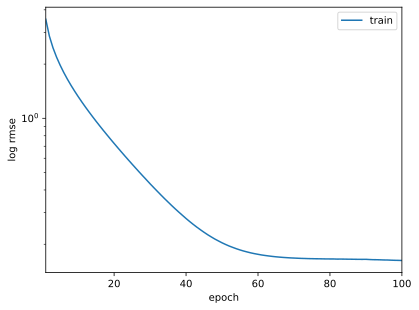

训练log rmse：0.162455


In [29]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)